In [3]:
%cd /Users/gwg/local/dmcm
%matplotlib inline

/Users/gwg/local/dmcm


In [4]:
import random

from   sklearn import manifold, decomposition
from   sklearn import manifold, decomposition

import numpy as np

from   scipy.spatial.distance import cdist
from   scipy.sparse import coo_matrix

import matplotlib
import matplotlib.pyplot as plt
from   matplotlib.offsetbox import OffsetImage, AnnotationBbox

import torch
from   torch import nn
from   torch.autograd import Variable
from   torchvision.utils import save_image

from   models import load_trained_model
from   data.synth.config import SynthConfig
from   data import SynthDataset
import plotutils

In [21]:
def analyze_model(subdir):
    fname = subdir + '/model.pt'
    config  = SynthConfig()
    model = load_trained_model(config, fname, cpu=True)

    l1_loss   = nn.L1Loss(size_average=True)
    reg_loss  = 0
    n_params  = 0
    n_zeros   = 0

    for param in model.gene_matrix.parameters():
        n_params += np.prod(param.size())
        n_zeros  += np.isclose(param.data.numpy(), 0).sum()
        target    = Variable(torch.Tensor(param.size()).fill_(0))
        reg_loss += l1_loss(param, target)

    params = [p for p in model.gene_matrix.parameters()][0]
    print('n_zeros: %s' % n_zeros)
    sparsity = n_zeros / n_params

    return params, sparsity, reg_loss.data[0]

# ------------------------------------------------------------------------------

def get_dir(base, l1_coef):
    if l1_coef == 0:
        return base + '/synth_lr-0.0001'
    else:
        return base + '/synth_l1_coef-%s_lr-0.0001' % l1_coef

In [22]:
BASE = '/Users/gwg/local/dmcm/experiments/20180312_l1_penalty'
l1_coefs = [1000.0, 2500.0, 5000.0, 7500.0, 10000.0]

sparsities = []
matrices = []

for l1_coef in l1_coefs:
    print('=' * 80)
    print(l1_coef)
    
    subdir = get_dir(BASE, l1_coef)
    
    param, sparsity, reg_loss = analyze_model(subdir)
    print(param.norm(1).data.numpy()[0])
    sparsities.append(sparsity) 
    param = param.data.numpy()
    sparse_matrix = coo_matrix(np.isclose(param, 0))
    matrices.append(sparse_matrix)
    
print('Done analysis.')

1000.0
n_zeros: 0
0.000816792
2500.0
n_zeros: 0
0.000673503
5000.0
n_zeros: 0
0.00065486
7500.0
n_zeros: 0
0.00055211
10000.0
n_zeros: 0
0.000621874
Done analysis.


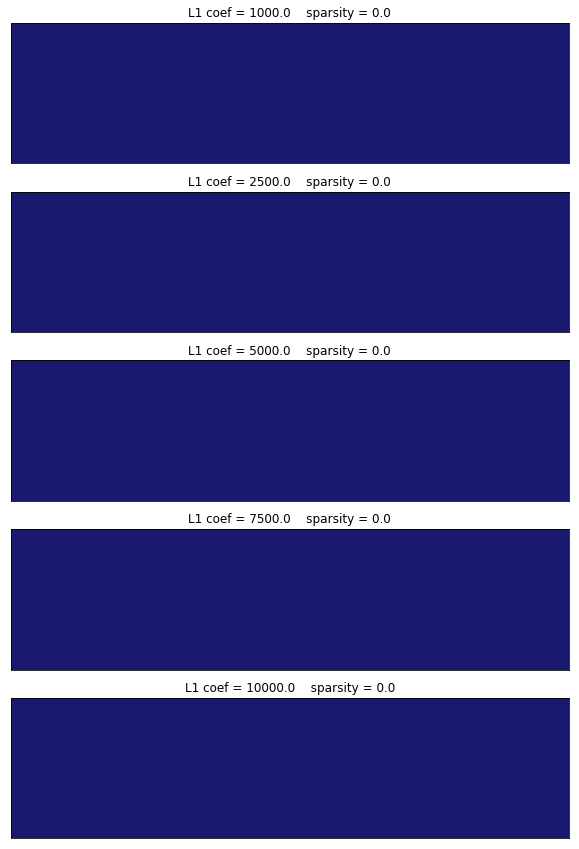

In [15]:
fig, axes = plt.subplots(nrows=len(matrices), ncols=1)

# ax = axes
# i = 0
# m = matrices[i]

for i, (m, ax) in enumerate(zip(matrices, axes)):

    ax.set_title('L1 coef = %s    sparsity = %s' % (
        l1_coefs[i], round(sparsities[i], 6)))

    # Background color is black.
    ax.set_facecolor('midnightblue')
    # The data point is white if is it zero.
    ax.plot(m.col, m.row, 's', color='white', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])

    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])

# fig.tight_layout()
fig.set_size_inches(10, 15)
plt.show()

In [16]:
# fig, axes = plt.subplots(2, sharex=True)
# fig.set_size_inches(10, 8)

# ax0 = axes[0]
# ax1 = axes[1]

# ax0.set_xlim([0, 1])

# ax0.set_ylabel('Sparsity')
# ax0.scatter(l1_coefs, sparsities)

# ax1.set_xlabel('L1 coef')